In [1]:
import os

from lxml import etree
import base64
import xmltodict
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
from nltk.tokenize import RegexpTokenizer
import pymorphy2

import json
from elasticsearch import Elasticsearch
from elasticsearch.helpers import parallel_bulk
import time

import numpy as np
import networkx as nx

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

BYWEB_PATH = os.path.join('data', 'byweb_for_course')
RELEVANT_TABLE = os.path.join('data', 'relevant_table_2009.xml')
QUERY_TABLE = os.path.join('data', 'web2008_adhoc.xml')

In [2]:
class Document:
    def __init__(self, raw):
        self.raw = raw

In [3]:
def pipeline(docs, foo_list):
    for foo in foo_list:
        def generator(docs, foo):
            for doc in docs:
                yield foo(doc)
        docs = generator(docs, foo)
    return docs

def generate_raw_docs(db_path):
    for file_name in tqdm(os.listdir(db_path)):
        file_path = os.path.join(db_path, file_name)
        root = etree.parse(file_path).getroot()
        for raw in root.getchildren():
            yield Document(raw)

In [4]:
def decoded_doc(doc):
    doc.html, doc.url, doc.doc_id = \
        list(map(lambda x: x.text, doc.raw))
    doc.url = base64.urlsafe_b64decode(doc.url).decode('cp1251')
    doc.html = base64.b64decode(doc.html).decode('cp1251')
    return doc

In [5]:
def build_text(doc):
    soup = BeautifulSoup(doc.html, 'lxml')
    
    for script in soup(['script', 'style']):
        script.decompose()
    doc.text = soup.get_text()
    doc.text = re.sub('(<!--.*?-->)', '', doc.text, flags=re.DOTALL)
    
    doc.title = soup.title.string if soup.title and soup.title.string else ''
    
    return doc

In [6]:
def get_tokenize_foo():
    tokenizer = RegexpTokenizer(r'\w+')
    def tokenize(doc):
        doc.title_tokens = tokenizer.tokenize(doc.title)
        doc.tokens = tokenizer.tokenize(doc.text)
        return doc
    return tokenize

In [7]:
def get_lemmatization_foo():
    analyzer = pymorphy2.MorphAnalyzer()
    def lemmatization(doc):
        doc.lemmed_tokens = list(map(lambda x: x.lower(), doc.tokens))
        doc.lemmed_tokens = list(map(lambda x: analyzer.parse(x)[0].normal_form, doc.lemmed_tokens))
        
        doc.title_lemmed_tokens = list(map(lambda x: x.lower(), doc.title_tokens))
        doc.title_lemmed_tokens = list(map(lambda x: analyzer.parse(x)[0].normal_form, doc.title_lemmed_tokens))
        
        return doc
    return lemmatization

In [8]:
def find_links(doc):
    soup = BeautifulSoup(doc.html)
    for script in soup(["script", "style"]):
        script.decompose()
    
    doc.links = set()
    for link in soup.findAll('a'):
        link_url = link.get('href')
        if not link_url or link_url[0] == '#':
            continue
        try:
            link_url = urljoin(doc.url, link_url)
            doc.links.add(link_url)
        except Exception:
            pass
        
    return doc

In [9]:
es = Elasticsearch([{
    'host': 'localhost',
    'port': 9200,
    'timeout': 360,
    'maxsize': 25
}])

In [10]:
def recreate_index(body):
    try:
        es.indices.delete(index='myandex')
    except:
        pass
        
    es.indices.create(index='myandex', body=body)

In [11]:
settings = {
    "settings": {
        "analysis": {
            'char_filter': {
                'my_yont': {
                    'type': 'mapping',
                    'mappings': [
                        'ё => е',
                        'Ё => Е'
                    ]
                }
            },
            'tokenizer': {
                'my_word_longer_2': {
                    'type': 'pattern',
                    'pattern': '[a-zA-Z_0-9\u0400-\u04FF]{2,}',
                    'group': 0
                }
            },
            'filter': {
                "my_ru_stop": {
                    "type": "stop",
                    "stopwords": "_russian_"
                },
                "my_en_stop": {
                    "type": "stop",
                    "stopwords": "_english_"
                },
                'my_en_snow': {
                    'type': 'snowball',
                    'language': 'english'
                },
                'my_ru_snow': {
                    'type': 'snowball',
                    'language': 'russian'
                }
            },
            "analyzer": {
                "my_analyzer": {
                    "type": "custom", 
                    "tokenizer": "my_word_longer_2",
                    "char_filter": [
                        "my_yont"
                    ],
                    "filter": [
                        "lowercase",
                        "asciifolding",
                        "my_ru_stop",
                        "my_en_stop"
                    ]
                },
                "my_snow_analyzer": {
                    "type": "custom", 
                    "tokenizer": "my_word_longer_2",
                    "char_filter": [
                        "my_yont"
                    ],
                    "filter": [
                        "lowercase",
                        "asciifolding",
                        "my_ru_stop",
                        "my_en_stop",
                        "my_ru_snow",
                        "my_en_snow"
                    ]
                },
                "my_html_analyzer": {
                    "type": "custom", 
                    "tokenizer": "my_word_longer_2",
                    "char_filter": [
                        "html_strip",
                        "my_yont"
                    ],
                    "filter": [
                        "lowercase",
                        "asciifolding",
                        "my_ru_stop",
                        "my_en_stop"
                    ]
                },
                "my_html_snow_analyzer": {
                    "type": "custom", 
                    "tokenizer": "my_word_longer_2",
                    "char_filter": [
                        "html_strip",
                        "my_yont"
                    ],
                    "filter": [
                        "lowercase",
                        "asciifolding",
                        "my_ru_stop",
                        "my_en_stop",
                        "my_ru_snow",
                        "my_en_snow"
                    ]
                }
            }
        }
    },
    'mappings': {
        'properties': {
            'src_text': {
                'type': 'text',
                'analyzer': 'my_html_analyzer'
            },
            'snow_text': {
                'type': 'text',
                'analyzer': 'my_html_snow_analyzer'
            },
            'lem_text': {
                'type': 'text',
                'analyzer': 'my_analyzer'
            },
            'src_title': {
                'type': 'text',
                'analyzer': 'my_analyzer'
            },
            'snow_title': {
                'type': 'text',
                'analyzer': 'my_snow_analyzer'
            },
            'lem_title': {
                'type': 'text',
                'analyzer': 'my_analyzer'
            },
            'pagerank': {
                'type': 'rank_feature'
            }
        }
    }
}

recreate_index(settings)

In [12]:
docs_generator = pipeline(generate_raw_docs(BYWEB_PATH),
                          [decoded_doc,
                           find_links])

url_to_doc_id = {}
graph_links = {}
for doc in docs_generator:
    url_to_doc_id[doc.url] = doc.doc_id
    graph_links[doc.doc_id] = doc.links

In [13]:
docs = {}
for doc_id in graph_links:
    docs[doc_id] = set([url_to_doc_id[url] for url in graph_links[doc_id] if url in url_to_doc_id])

In [14]:
G = nx.DiGraph()
G.add_nodes_from(docs.keys())
for doc_a, links in docs.items():
    for doc_b in links:
        G.add_edge(doc_a, doc_b)

page_rank = nx.pagerank(G, alpha=0.85)

In [15]:
docs_generator = pipeline(generate_raw_docs(BYWEB_PATH),
                          [decoded_doc, 
                           build_text, 
                           get_tokenize_foo(), 
                           get_lemmatization_foo()])

def es_actions_generator():
    for doc in docs_generator:        
        yield {
            '_index': 'myandex',
            '_id': doc.doc_id,
            '_source': {
                'src_text': doc.html,
                'snow_text': doc.html,
                'lem_text': doc.lemmed_tokens,
                'src_title': doc.title_tokens,
                'snow_title': doc.title_tokens,
                'lem_title': doc.title_lemmed_tokens,
                'pagerank': page_rank.get(doc.doc_id),
            }
        }
        
for ok, result in parallel_bulk(es, es_actions_generator(), queue_size=4, thread_count=4, chunk_size=1000):
    if not ok:
        print(result)

TransportError: TransportError(429, 'circuit_breaking_exception', '[parent] Data too large, data for [<http_request>] would be [1014977250/967.9mb], which is larger than the limit of [986061209/940.3mb], real usage: [807603544/770.1mb], new bytes reserved: [207373706/197.7mb], usages [request=0/0b, fielddata=0/0b, in_flight_requests=207373706/197.7mb, accounting=49484/48.3kb]')

In [16]:
index_size = es.indices.stats('myandex')['_all']['primaries']['store']['size_in_bytes'] / 2 ** 30
print("Size of index: {:.4} GB".format(index_size))

Size of index: 4.502 GB


In [17]:
def search(query):
    search_result = es.search(index='myandex', body=query, size=20)['hits']
    return [(hit['_id'], hit['_score']) for hit in search_result['hits']]

In [18]:
tasks = {}

with open(RELEVANT_TABLE, 'rb') as file:
    xmldict = xmltodict.parse(file.read())
    for task in tqdm(xmldict['taskDocumentMatrix']['task']):
        task_id = task['@id']
        tasks[task_id] = {'pos': set(), 'neg': set()}
        for doc in task['document']:
            if doc['@relevance'] == 'vital':
                tasks[task_id]['pos'].add(doc['@id'])
            else:
                tasks[task_id]['neg'].add(doc['@id'])
            
with open(QUERY_TABLE, 'rb') as f:
    xmldict = xmltodict.parse(f.read())
    for task in tqdm(xmldict['task-set']['task']):
        task_id = task['@id']
        if task_id in tasks:
            tasks[task_id]['querytext'] = task['querytext']
            
for task_id in tasks:
    tasks[task_id]['pos'] = [id for id in tasks[task_id]['pos'] if id in docs]
    tasks[task_id]['neg'] = [id for id in tasks[task_id]['neg'] if id in docs]
    
tasks = {id: task for id, task in tasks.items() if len(task['pos']) > 0}

In [19]:
get_query = lambda q: {
    'query': {
        'bool': {
            'should': {
                'match': {
                    'src_text': q
                }
            }
        }
    }
}

start_time = time.time()
for _, task in tqdm(tasks.items()):
    search(get_query(task['querytext']))
end_time = time.time()
spend_time = time.gmtime((end_time - start_time) / len(tasks) * 1000)
print("1000 search requests took: {}".format(time.strftime('%S.%l', spend_time)))


1000 search requests took: 42.12


In [35]:
def in_top_k(res, task, k):
    return sum(int(id in task['pos']) for id, _ in res[:k])

def evaluate(tasks, get_query, show=True):
    metrics = {x: [] for x in ['pq', 'rq', 'prq', 'mapq']}
    for _, task in tqdm(tasks.items()):
        res = search(get_query(task['querytext']))
        sk = in_top_k(res, task, 20)
        metrics['pq'].append(sk / 20)
        cnt_pos = len(task['pos'])
        metrics['rq'].append(sk / min(cnt_pos, 20))
        metrics['prq'].append(in_top_k(res, task, cnt_pos) / cnt_pos)
        metrics['mapq'].append(sum(in_top_k(res, task, k) / k for k in range(1, 21)) / 20)
        
    for x in metrics:
        metrics[x] = np.array(metrics[x])
        
    if show:
        print("p@20: {:.4}".format(metrics['pq'].mean()))
        print("r@20: {:.4}".format(metrics['rq'].mean()))
        print("p@R: {:.4}".format(metrics['prq'].mean()))
        print("map@20: {:.4}".format(metrics['mapq'].mean()))
    
    return metrics

In [21]:
get_query = lambda q: {
    'query': {
        'bool': {
            'should': {
                'match': {
                    'src_text': q
                }
            }
        }
    }
}

metrics = evaluate(tasks, get_query)


p@20: 0.2746
r@20: 0.3257
p@R: 0.1666
map@20: 0.3558


In [22]:
get_query = lambda q: {
    'query': {
        'bool': {
            'should': {
                'match': {
                    'snow_text': q
                }
            }
        }
    }
}

snow_metrics = evaluate(tasks, get_query)


p@20: 0.3178
r@20: 0.3859
p@R: 0.1967
map@20: 0.3915


In [23]:
tokenizer = RegexpTokenizer(r'\w+')
analyzer = pymorphy2.MorphAnalyzer()

def get_query(q): 
    q = tokenizer.tokenize(q)
    q = list(map(lambda x: x.lower(), q))
    q = list(map(lambda x: analyzer.parse(x)[0].normal_form, q))
    q = ' '.join(q)
    return {
        'query': {
            'bool': {
                'should': {
                    'match': {
                        'lem_text': q
                    }
                }
            }
        }
    }

lem_metrics = evaluate(tasks, get_query)


p@20: 0.3269
r@20: 0.3934
p@R: 0.2011
map@20: 0.4006


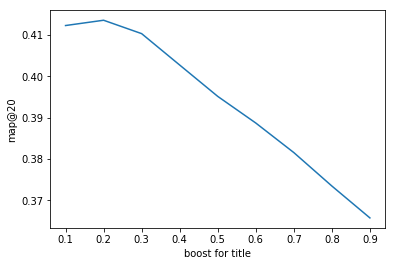

In [41]:
tokenizer = RegexpTokenizer(r'\w+')
analyzer = pymorphy2.MorphAnalyzer()

def get_query(q, boost):
    q = tokenizer.tokenize(q)
    q = list(map(lambda x: x.lower(), q))
    q = list(map(lambda x: analyzer.parse(x)[0].normal_form, q))
    q = ' '.join(q)
    return {
        'query': {
            'bool': {
                'should': [
                    {
                        "match": {
                            "lem_text": q
                        }
                    },
                    {
                        "match": {
                            "lem_title": {
                                "query" : q,
                                "boost": boost
                            }
                        }
                    }
                ]
            }
        }
    }

xs = np.arange(0.1, 1, 0.1).tolist()
ys = [evaluate(tasks, lambda q: get_query(q, x), show=False)['mapq'].mean() for x in xs]

plt.plot(xs, ys)
plt.xlabel('boost for title')
plt.ylabel('map@20')
plt.show()

p@20: 0.3373
r@20: 0.4021
p@R: 0.2023
map@20: 0.4135


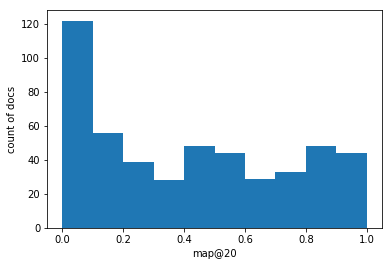

In [48]:
lem_title_metrics = evaluate(tasks, lambda q: get_query(q, 0.2))

plt.hist(lem_title_metrics['mapq'])
plt.xlabel('map@20')
plt.ylabel('count of docs')
plt.show()

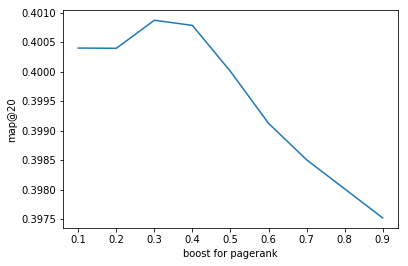

In [39]:
tokenizer = RegexpTokenizer(r'\w+')
analyzer = pymorphy2.MorphAnalyzer()

def get_query(q, boost):
    q = tokenizer.tokenize(q)
    q = list(map(lambda x: x.lower(), q))
    q = list(map(lambda x: analyzer.parse(x)[0].normal_form, q))
    q = ' '.join(q)
    return {
        'query': {
            'bool': {
                'should': [
                    {
                        "match": {
                            "lem_text": q
                        }
                    },
                    {
                        "rank_feature": {
                            "field": "pagerank",
                            "boost": boost
                        }
                    }
                ]
            }
        }
    }

xs = np.arange(0.1, 1, 0.1).tolist()
ys = [evaluate(tasks, lambda q: get_query(q, x), show=False)['mapq'].mean() for x in xs]

plt.plot(xs, ys)
plt.xlabel('boost for pagerank')
plt.ylabel('map@20')
plt.show()

In [40]:
metrics_pagerank = evaluate(tasks, lambda q: get_query(q, 0.3))

p@20: 0.3281
r@20: 0.3948
p@R: 0.1998
map@20: 0.4009


In [26]:
diff = np.abs(snow_metrics['mapq'] - lem_metrics['mapq'])
nums = diff.argsort()[::-1][:3]

tasks_list = [task for _, task in tasks.items()]

for num in nums:
    print("query: {}".format(tasks_list[num]['querytext']))
    print("map@20 snow: {:.4}".format(snow_metrics['mapq'][num]))
    print("map@20 lem: {:.4}".format(lem_metrics['mapq'][num]))
    print()

query: УРАЛЬСКАЯ ПЛИТКА
map@20 snow: 0.9423
map@20 lem: 0.1799

query: faq как настроить домен
map@20 snow: 0.3425
map@20 lem: 0.8552

query: эллинистический образец иконописи
map@20 snow: 0.3543
map@20 lem: 0.7956

